In [1]:
# Basic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
import warnings
warnings.filterwarnings(action='ignore')

# Data Preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

# Model Training
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import tensorflow as tf

# Import necessary modules for collaborative filtering
from tensorflow.keras.layers import Input, Embedding, Dot, Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from collections import defaultdict
from collections import Counter

# Import necessary modules for content-based filtering
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

2024-08-04 12:16:11.018434: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-04 12:16:11.018548: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-04 12:16:11.137581: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
!nvidia-smi

Sun Aug  4 12:16:31 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.90.07              Driver Version: 550.90.07      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-PCIE-16GB           Off |   00000000:00:04.0 Off |                    0 |
| N/A   33C    P0             26W /  250W |       0MiB /  16384MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# Collaborative Filtering Embedding Generation

In [3]:
# Load the dataset
df=pd.read_csv('/kaggle/input/myanimelist-dataset/users-score-2023.csv', usecols=["user_id","anime_id","rating"])
print("Shape of the Dataset:",df.shape)
df.head()

Shape of the Dataset: (24325191, 3)


,user_id,anime_id,rating
0,1,21,9
1,1,48,7
2,1,320,5
3,1,49,8
4,1,304,8


In [4]:
# Scale the 'score' column between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
df['scaled_score'] = scaler.fit_transform(df[['rating']])

# Encoding user IDs
user_encoder = LabelEncoder()
df["user_encoded"] = user_encoder.fit_transform(df["user_id"])
num_users = len(user_encoder.classes_)

# Encoding anime IDs
anime_encoder = LabelEncoder()
df["anime_encoded"] = anime_encoder.fit_transform(df["anime_id"])
num_animes = len(anime_encoder.classes_)

# Printing dataset information
print("Number of unique users: {}, Number of unique anime: {}".format(num_users, num_animes))

Number of unique users: 270033, Number of unique anime: 16500


In [5]:
# Shuffle the dataset
df = shuffle(df, random_state=100)

# Create feature matrix X and target variable y
X = df[['user_encoded', 'anime_encoded']].values
y = df["scaled_score"].values

test_set_size = 10000  # Number of samples to include in the test set

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_set_size, random_state=73)

# Prepare input data for model training and evaluation
X_train_array = [X_train[:, 0], X_train[:, 1]]
X_test_array = [X_test[:, 0], X_test[:, 1]]

In [6]:
tf_version = tf.__version__
print(f"TensorFlow version: {tf_version}")

TensorFlow version: 2.15.0


In [7]:
def RecommenderNet(num_users, num_animes, embedding_size=128):
    # User input layer and embedding layer
    user = Input(name='user_encoded', shape=[1])
    user_embedding = Embedding(name='user_embedding', input_dim=num_users, output_dim=embedding_size)(user)
    
    # Anime input layer and embedding layer
    anime = Input(name='anime_encoded', shape=[1])
    anime_embedding = Embedding(name='anime_embedding', input_dim=num_animes, output_dim=embedding_size)(anime)
    
    # Dot product of user and anime embeddings
    dot_product = Dot(name='dot_product', normalize=True, axes=2)([user_embedding, anime_embedding])
    flattened = Flatten()(dot_product)
    
    # Dense layers for prediction
    dense = Dense(64, activation='relu')(flattened)
    output = Dense(1, activation='sigmoid')(dense)
    
    # Create and compile the model
    model = Model(inputs=[user, anime], outputs=output)
    model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=["mae", "mse"])
    return model

model = RecommenderNet(num_users, num_animes)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ user_encoded        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ anime_encoded       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_embedding      │ (None, 1, 128)    │ 34,564,224 │ user_encoded[0][… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ anime_embedding     │ (None, 1, 128)    │  2,112,000 │ anime_encoded[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot_product (Dot)   │ (None, 1, 1)      │          0 │ user_embedding[0… │
│                     │                   │            │ anime_embedding[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 1)         │          0 │ dot_product[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │        128 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │         65 │ dense[0][0]       │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 36,676,417 (139.91 MB)

 Trainable params: 36,676,417 (139.91 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
## Import necessary callbacks
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping

# Define the initial learning rate, minimum learning rate, maximum learning rate, and batch size
start_lr = 0.00001
min_lr = 0.00001
max_lr = 0.00005
batch_size = 10000

# Define the number of epochs for ramp-up, sustain, and exponential decay
rampup_epochs = 5
sustain_epochs = 0
exp_decay = .8

# Learning rate schedule function
def lrfn(epoch):
    if epoch < rampup_epochs:
        return (max_lr - start_lr) / rampup_epochs * epoch + start_lr
    elif epoch < rampup_epochs + sustain_epochs:
        return max_lr
    else:
        return (max_lr - min_lr) * exp_decay**(epoch - rampup_epochs - sustain_epochs) + min_lr

# Learning rate scheduler callback
lr_callback = LearningRateScheduler(lambda epoch: lrfn(epoch), verbose=0)

# File path for saving the model weights
checkpoint_filepath = '/kaggle/working/anime_collaborative.weights.h5'

# Model checkpoint callback to save the best weights
model_checkpoints = ModelCheckpoint(filepath=checkpoint_filepath,
                                    save_weights_only=True,
                                    monitor='val_loss',
                                    mode='min',
                                    save_best_only=True)

# Early stopping callback to prevent overfitting
early_stopping = EarlyStopping(patience=3, monitor='val_loss', mode='min', restore_best_weights=True)

# Define the list of callbacks
my_callbacks = [
    model_checkpoints,
    lr_callback,
    early_stopping
]

In [9]:
# Model training
history = model.fit(
    x=X_train_array,
    y=y_train,
    batch_size=batch_size,
    epochs=20,
    verbose=1,
    validation_data=(X_test_array, y_test),
    callbacks=my_callbacks
)

model.load_weights(checkpoint_filepath)

Epoch 1/20
  24/2432 ━━━━━━━━━━━━━━━━━━━━ 17s 7ms/step - loss: 0.6967 - mae: 0.2665 - mse: 0.0915

I0000 00:00:1722773875.139074     106 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2432/2432 ━━━━━━━━━━━━━━━━━━━━ 23s 8ms/step - loss: 0.6884 - mae: 0.2592 - mse: 0.0873 - val_loss: 0.6645 - val_mae: 0.2368 - val_mse: 0.0750 - learning_rate: 1.0000e-05
Epoch 2/20
2432/2432 ━━━━━━━━━━━━━━━━━━━━ 19s 7ms/step - loss: 0.6505 - mae: 0.2237 - mse: 0.0685 - val_loss: 0.6118 - val_mae: 0.1867 - val_mse: 0.0493 - learning_rate: 1.8000e-05
Epoch 3/20
2432/2432 ━━━━━━━━━━━━━━━━━━━━ 19s 7ms/step - loss: 0.5998 - mae: 0.1721 - mse: 0.0441 - val_loss: 0.5787 - val_mae: 0.1491 - val_mse: 0.0342 - learning_rate: 2.6000e-05
Epoch 4/20
2432/2432 ━━━━━━━━━━━━━━━━━━━━ 19s 7ms/step - loss: 0.5779 - mae: 0.1480 - mse: 0.0343 - val_loss: 0.5769 - val_mae: 0.1457 - val_mse: 0.0335 - learning_rate: 3.4000e-05
Epoch 5/20
2432/2432 ━━━━━━━━━━━━━━━━━━━━ 18s 7ms/step - loss: 0.5768 - mae: 0.1458 - mse: 0.0339 - val_loss: 0.5760 - val_mae: 0.1433 - val_mse: 0.0331 - learning_rate: 4.2000e-05
Epoch 6/20
2432/2432 ━━━━━━━━━━━━━━━━━━━━ 19s 7ms/step - loss: 0.5677 - mae: 0.1352 - mse: 0.0303 - val_lo

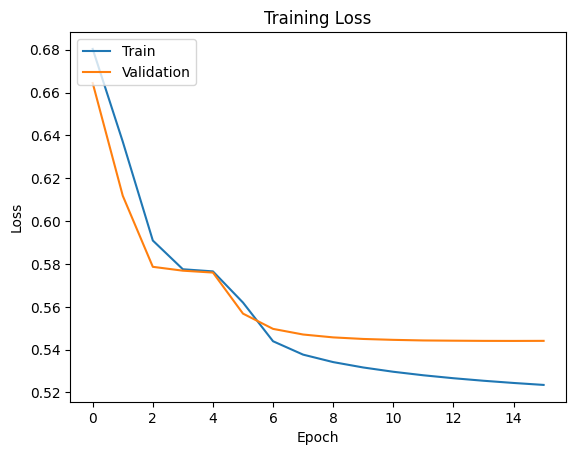

In [10]:
# Training results visualization

plt.plot(history.history["loss"][0:-2])
plt.plot(history.history["val_loss"][0:-2])
plt.title("Training Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Train", "Validation"], loc="upper left")
plt.show()

In [28]:
def extract_weights(name, model):
    weight_layer = model.get_layer(name)
    weights = weight_layer.get_weights()[0]
    weights = weights / np.linalg.norm(weights, axis=1).reshape((-1, 1))
    return weights

# Extract weights for anime embeddings
anime_weights = extract_weights('anime_embedding', model)
collaborative_filtering_df = pd.DataFrame(anime_weights)
collaborative_filtering_df['anime_id'] = collaborative_filtering_df.apply(lambda row: anime_encoder.inverse_transform([row.name])[0], axis = 1)

In [30]:
# File path for saving the embedding
collaborative_filtering_embeddings_filepath = '/kaggle/working/collaborative_filtering_embeddings.csv'
collaborative_filtering_df.to_csv(collaborative_filtering_embeddings_filepath)

# Content Based Embedding Generation

In [41]:
# Load the dataset
df_anime=pd.read_csv('/kaggle/input/myanimelist-dataset/anime-dataset-2023.csv')

In [67]:
# only give rating of those movies for which atleast X user have rated
popularity_threshold = 1000
df_anime= df_anime[df_anime['Members'] >= popularity_threshold]
print(df_anime.shape)
df_anime.head()

(12638, 24)


,anime_id,Name,English name,Other name,Score,Genres,Synopsis,Type,Episodes,Aired,...,Studios,Source,Duration,Rating,Rank,Popularity,Favorites,Scored By,Members,Image URL
0,1,Cowboy Bebop,Cowboy Bebop,カウボーイビバップ,8.75,"Action, Award Winning, Sci-Fi","Crime is timeless. By the year 2071, humanity ...",TV,26.0,"Apr 3, 1998 to Apr 24, 1999",...,Sunrise,Original,24 min per ep,R - 17+ (violence & profanity),41.0,43,78525,914193.0,1771505,https://cdn.myanimelist.net/images/anime/4/196...
1,5,Cowboy Bebop: Tengoku no Tobira,Cowboy Bebop: The Movie,カウボーイビバップ 天国の扉,8.38,"Action, Sci-Fi","Another day, another bounty—such is the life o...",Movie,1.0,"Sep 1, 2001",...,Bones,Original,1 hr 55 min,R - 17+ (violence & profanity),189.0,602,1448,206248.0,360978,https://cdn.myanimelist.net/images/anime/1439/...
2,6,Trigun,Trigun,トライガン,8.22,"Action, Adventure, Sci-Fi","Vash the Stampede is the man with a $$60,000,0...",TV,26.0,"Apr 1, 1998 to Sep 30, 1998",...,Madhouse,Manga,24 min per ep,PG-13 - Teens 13 or older,328.0,246,15035,356739.0,727252,https://cdn.myanimelist.net/images/anime/7/203...
3,7,Witch Hunter Robin,Witch Hunter Robin,Witch Hunter ROBIN (ウイッチハンターロビン),7.25,"Action, Drama, Mystery, Supernatural",Robin Sena is a powerful craft user drafted in...,TV,26.0,"Jul 3, 2002 to Dec 25, 2002",...,Sunrise,Original,25 min per ep,PG-13 - Teens 13 or older,2764.0,1795,613,42829.0,111931,https://cdn.myanimelist.net/images/anime/10/19...
4,8,Bouken Ou Beet,Beet the Vandel Buster,冒険王ビィト,6.94,"Adventure, Fantasy, Supernatural",It is the dark century and the people are suff...,TV,52.0,"Sep 30, 2004 to Sep 29, 2005",...,Toei Animation,Manga,23 min per ep,PG - Children,4240.0,5126,14,6413.0,15001,https://cdn.myanimelist.net/images/anime/7/215...


In [68]:
# File path for saving the filtered animes
anime_dataset_filepath = '/kaggle/working/anime_dataset.csv'
df_anime.to_csv(anime_dataset_filepath)

In [65]:
# Create a TF-IDF vectorizer
tfidf = TfidfVectorizer(stop_words='english')

# Define a generator to compute TF-IDF matrix on the fly
tfidf_matrix_generator = tfidf.fit_transform((genre for genre in df_anime['Genres'].values.astype('U')))

content_based_df = pd.DataFrame(tfidf_matrix_generator.toarray())
content_based_df['anime_id'] = df_anime['anime_id']
print(content_based_df.shape)
content_based_df.head()

(12638, 28)


,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,anime_id
0,0.259908,0.000000,0.0,0.604519,0.0,0.0,0.000000,0.0,0.0,0.00000,...,0.000000,0.0,0.317461,0.0,0.0,0.000000,0.0,0.0,0.604519,1.0
1,0.501015,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.00000,...,0.000000,0.0,0.611957,0.0,0.0,0.000000,0.0,0.0,0.000000,5.0
2,0.429127,0.516123,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.00000,...,0.000000,0.0,0.524150,0.0,0.0,0.000000,0.0,0.0,0.000000,6.0
3,0.356011,0.000000,0.0,0.000000,0.0,0.0,0.452928,0.0,0.0,0.00000,...,0.617413,0.0,0.000000,0.0,0.0,0.535643,0.0,0.0,0.000000,7.0
4,0.000000,0.540834,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.49976,...,0.000000,0.0,0.000000,0.0,0.0,0.676563,0.0,0.0,0.000000,8.0


In [66]:
# File path for saving content-based embeddings
content_based_embeddings_filepath = '/kaggle/working/content_based_embeddings.csv'
content_based_df.to_csv(content_based_embeddings_filepath)